In [2]:
import sys

sys.path.append("..")
from cge_modeling import CGEModel, Variable, Parameter, Equation
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import sympy as sp

In [4]:
df = pd.read_csv("data/lesson_3_sam.csv", index_col=[0, 1], header=[0, 1]).map(float).fillna(0)
assert np.allclose(df.sum(axis=0), df.sum(axis=1))
df

Factor         Institution                  \
                          Labor Capital   Household   Firms    Govt   
Factor      Labor           0.0     0.0         0.0     0.0     0.0   
            Capital         0.0     0.0         0.0     0.0     0.0   
Institution Household    7200.0     0.0         0.0  2800.0     0.0   
            Firms           0.0  2800.0         0.0     0.0     0.0   
            Govt            0.0     0.0      3700.0     0.0     0.0   
Production  Agriculture     0.0     0.0      1700.0     0.0   400.0   
            Industry        0.0     0.0      1200.0     0.0  1500.0   
            Services        0.0     0.0      3400.0     0.0  2300.0   
Activities  Agriculture     0.0     0.0         0.0     0.0     0.0   
            Industry        0.0     0.0         0.0     0.0     0.0   
            Services        0.0     0.0         0.0     0.0     0.0   

                         Production                    Activities           \
                        Agriculture Industry Services Agriculture Industry   
Factor      Labor               0.0      0.0      0.0      1300.0   1900.0   
            Capital             0.0      0.0      0.0       200.0   2100.0   
Institution Household           0.0      0.0      0.0         0.0      0.0   
            Firms               0.0      0.0      0.0         0.0      0.0   
            Govt              100.0    220.0    180.0         0.0      0.0   
Production  Agriculture         0.0      0.0      0.0      1000.0   1000.0   
            Industry            0.0      0.0      0.0      2010.0   3510.0   
            Services            0.0      0.0      0.0       490.0   2490.0   
Activities  Agriculture      5000.0      0.0      0.0         0.0      0.0   
            Industry            0.0  11000.0      0.0         0.0      0.0   
            Services            0.0      0.0   9500.0         0.0      0.0   

                                  
                        Services  
Factor      Labor         4000.0  
            Capital        500.0  
Institution Household        0.0  
            Firms            0.0  
            Govt             0.0  
Production  Agriculture   1000.0  
            Industry      3000.0  
            Services      1000.0  
Activities  Agriculture      0.0  
            Industry         0.0  
            Services         0.0

In [5]:
sectors = ["Ag", "Ind", "Serv"]
coords = {"i": sectors, "j": sectors}

In [292]:
variable_info = [
    Variable(name="Y", dims="i", description="Final output in the <dim:i> sector"),
    Variable(name="VA", dims="i", description="Value-added component of <dim:i> sector production"),
    Variable(name="VC", dims="i", description="Value-chain component of <dim:i> sector production"),
    Variable(
        name="X",
        dims=("i", "j"),
        description="Demand for <dim:i> sector goods by the <dim:j> sector as value-chain inputs",
    ),
    Variable(name="C", dims="i", description="Household consumption of <dim:i> goods"),
    Variable(
        name="C_G",
        dims="i",
        extend_subscript=True,
        description="Government consumption of <dim:i> goods",
    ),
    Variable(
        name="L_d",
        dims="i",
        extend_subscript=True,
        description="Labor demand in the <dim:i> sector",
    ),
    Variable(
        name="K_d",
        dims="i",
        extend_subscript=True,
        description="Capital demand in the <dim:i> sector",
    ),
    Variable(name="P", dims="i", description="Final good price in the <dim:i> sector, after taxes"),
    Variable(
        name="P_VA",
        dims="i",
        extend_subscript=True,
        description="Price of the value-add component in the <dim:i> sector",
    ),
    Variable(
        name="P_VC",
        dims="i",
        extend_subscript=True,
        description="Price of the value-chain component in the <dim:i> sector",
    ),
    Variable(
        name="P_Y",
        dims="i",
        extend_subscript=True,
        description="Final good price in the <dim:i> sector, before taxes",
    ),
    Variable(name="income_tax", latex_name=r"T_{\Omega}", description="Income tax revenue"),
    Variable(name="U", description="Household utility"),
    Variable(name="income", latex_name="Omega", description="Household income, before taxes"),
    Variable(
        name="net_income", latex_name="\hat{\Omega}", description="Household income, after taxes"
    ),
    Variable(name="G", description="Government budget"),
    Variable(name="r", description="Rental rate of capital"),
    Variable(name="w", description="Wage level"),
    Variable(name="resid", latex_name=r"varepsilon", description="Walrasian residual"),
]


param_info = [
    Parameter(
        "psi_VA",
        extend_subscript=True,
        dims="i",
        description="Share of value-add bundle in <dim:i> sector final good production",
    ),
    Parameter(
        "psi_VC",
        extend_subscript=True,
        dims="i",
        description="Share of value chain bundle in <dim:i> sector final good production",
    ),
    Parameter(
        "psi_X",
        extend_subscript=True,
        dims=("i", "j"),
        description="Share of <dim:j> sector final goods in the <dim:i> value chain bundle",
    ),
    Parameter(
        "alpha",
        dims="i",
        description="Share of capital in production of the <dim:i> sector value-add bundle",
    ),
    Parameter("A", dims="i", description="Total factor productivity of the <dim:i> sector"),
    Parameter(
        "alpha_G",
        dims="i",
        description="Share of <dim:i> sector final goods in governmnet consumption",
    ),
    Parameter("tau", dims="i", description="Sales tax rate on final goods in the <dim:i> sector"),
    Parameter("tau_income", latex_name=r"\tau_{\Omega}", description="Income tax rate"),
    Parameter(
        "gamma",
        dims="i",
        description="Household elasticity of consumption utility for <dim:i> sector goods",
    ),
    Parameter("L_s", description="Exogenous labor supply"),
    Parameter("K_s", description="Exogenous capital supply"),
    Parameter("P_Ag_bar", latex_name=r"\bar{P}_{Ag}", description="Numeraire price"),
]


equations = [
    # Frim Block
    Equation("Final good production of sector <dim:i>", "P_Y * Y = P_VC * VC + P_VA * VA"),
    Equation("Sector <dim:i> demand for value chain bundle", "VC = psi_VC * Y"),
    Equation("Sector <dim:i> demand for value-add bundle", "VA = psi_VA * Y"),
    Equation("Sector <dim:i> production of labor-capital", "VA = A * K_d^alpha * L_d^(1-alpha)"),
    Equation("Sector <dim:i> demand for capital", "K_d = alpha * VA * P_VA / r"),
    Equation("Sector <dim:i> demand for labor", "L_d = (1 - alpha) * VA * P_VA / w"),
    Equation(
        "Sector <dim:i> production of value chain bundle",
        "VC * P_VC = Sum(P.subs({i:j}) * X.subs([(i,k), (j,i), (k,j)]), (j, 0, 2))",
    ),
    Equation("Demand for <dim:i> sector goods by <dim:j>", "X = psi_X * VC.subs({i:j})"),
    # Government block
    Equation(
        "Government budget constraint", "tau_income * income + Sum(tau * P_Y * Y, (i, 0, 2)) = G"
    ),
    Equation("Government consumption of <dim:i> sector goods", "P * C_G = alpha_G * G"),
    Equation("Definition of income tax", "income_tax = income - net_income"),
    Equation("Section <dim:i> after-tax price", "P = (1 + tau) * P_Y"),
    # Household block
    Equation("Household pre-tax income", "income = w * L_s + r * K_s"),
    Equation("Household after-tax income", "net_income = (1 - tau_income) * income"),
    Equation("Household utility", "U = Product(C**gamma, (i, 0, 2))"),
    Equation("Household demand for good <dim:i>", "C = gamma * net_income / P"),
    # Economic equilibrium
    Equation("Labor market clearing", "L_s = Sum(L_d, (i, 0, 2)) + resid"),
    Equation("Capital market clearing", "K_s = Sum(K_d, (i, 0, 2))"),
    Equation("<dim:i> sector goods market clearing", "Y = C + Sum(X, (j, 0, 2)) + C_G"),
    Equation("Numeraire", 'P.subs({i:"Ag"}) = P_Ag_bar'),
]

assert len(variable_info) == len(
    equations
), f"Found {len(variable_info)} variables but {len(equations)} equations"

In [293]:
mod = CGEModel(variables=variable_info, parameters=param_info, equations=equations, coords=coords)

In [294]:
mod.equation_table()

<IPython.core.display.Latex object>

In [303]:
short_to_long = {"Ag": "Agriculture", "Ind": "Industry", "Serv": "Services"}

# Normalize prices
initial_values = {"w": 1, "r": 1, "resid": 0}
initial_values.update({f"P_VA_{s}": 1 for s in sectors})
initial_values.update({f"P_VC_{s}": 1 for s in sectors})
initial_values.update({f"P_Y_{s}": 1 for s in sectors})

# # Enter data from SAM
initial_values["income_tax"] = df.loc[("Institution", "Govt"), ("Institution", "Household")]
for sector in sectors:
    long_sector = short_to_long[sector]
    initial_values[f"L_d_{sector}"] = (
        df.loc[("Factor", "Labor"), ("Activities", long_sector)] / initial_values["w"]
    )
    initial_values[f"K_d_{sector}"] = (
        df.loc[("Factor", "Capital"), ("Activities", long_sector)] / initial_values["r"]
    )
    initial_values[f"C_G_{sector}"] = df.loc[("Production", long_sector), ("Institution", "Govt")]
    initial_values[f"sales_tax_{sector}"] = df.loc[
        ("Institution", "Govt"), ("Production", long_sector)
    ]
    initial_values[f"C_{sector}"] = df.loc[
        ("Production", long_sector), ("Institution", "Household")
    ]
    initial_values[f"Y_{sector}"] = df.sum(axis=0).loc[("Production", long_sector)]

    # Work out the tax rate from tax reciepts
    sector_tax_paid = initial_values[f"sales_tax_{sector}"]

    initial_values[f"tau_{sector}"] = sector_tax_paid / (
        initial_values[f"Y_{sector}"] - sector_tax_paid
    )
    initial_values[f"P_{sector}"] = initial_values[f"P_Y_{sector}"] * (
        1 + initial_values[f"tau_{sector}"]
    )

    # Adjust values in SAM to account for non-normalized prices
    P_adj = initial_values[f"P_{sector}"]
    for sector_j in sectors:
        long_sector_j = short_to_long[sector_j]
        SAM_idx = ("Production", long_sector), ("Activities", long_sector_j)
        initial_values[f"X_{sector}_{sector_j}"] = df.loc[SAM_idx] / P_adj

    demands_to_adjust = ["C", "C_G", "Y"]
    for demand in demands_to_adjust:
        initial_values[f"{demand}_{sector}"] = initial_values[f"{demand}_{sector}"] / P_adj

# Known aggregates
# Have to do this because income tax reciepts aren't a model equaiton. Very strange!
initial_values["L_s"] = sum(
    [initial_values[k] for k in initial_values.keys() if k.startswith("L_d_")]
)
initial_values["K_s"] = sum(
    [initial_values[k] for k in initial_values.keys() if k.startswith("K_d_")]
)

initial_values["income"] = (
    initial_values["w"] * initial_values["L_s"] + initial_values["r"] * initial_values["K_s"]
)
initial_values["tau_income"] = initial_values["income_tax"] / initial_values["income"]
initial_values["net_income"] = (1 - initial_values["tau_income"]) * initial_values["income"]

for sector in sectors:
    del initial_values[f"sales_tax_{sector}"]

In [305]:
initial_res = mod.calibrate(initial_values)

In [320]:
initial_res.to_frame().loc[lambda x: x.index.str.startswith("psi")]

,initial,fitted
psi_VA_Ag,NaN,0.300000
psi_VA_Ind,NaN,0.363636
psi_VA_Serv,NaN,0.473684
psi_VC_Ag,NaN,0.700000
psi_VC_Ind,NaN,0.636364
psi_VC_Serv,NaN,0.526316
psi_X_Ag_Ag,NaN,0.280112
psi_X_Ag_Ind,NaN,0.140056
psi_X_Ag_Serv,NaN,0.196078
psi_X_Ind_Ag,NaN,0.563025


In [310]:
tax_cut = mod.simulate(
    initial_res,
    final_delta_pct={"tau_income": 0.9},
    n_iter_euler=10,
    name="10% income tax cut",
    method="trust-krylov",
)

<Axes: >

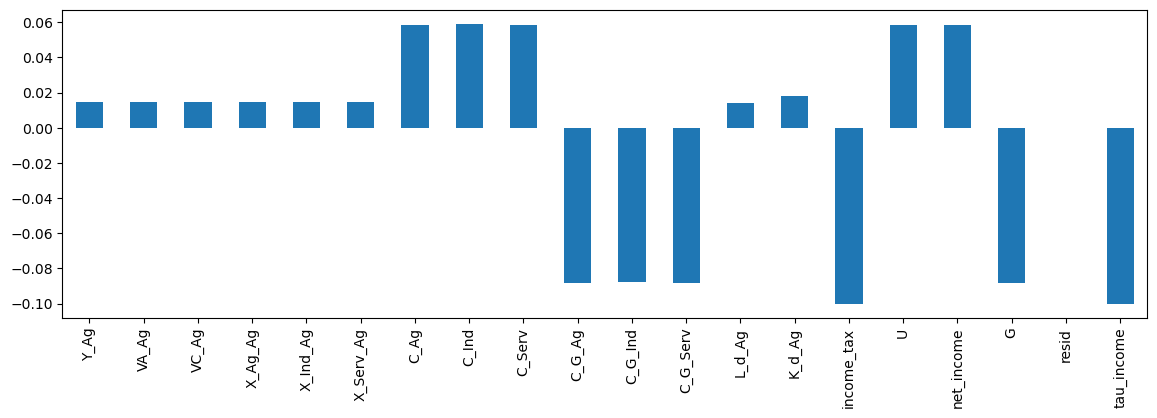

In [315]:
scenario_df = tax_cut.to_frame().copy()
scenario_df = scenario_df.assign(impact=lambda x: x.fitted / x.initial - 1)
scenario_df.impact.loc[lambda x: abs(x) > 1e-2].plot.bar(figsize=(14, 4))